In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model, decomposition, datasets
from sklearn.model_selection import train_test_split

from utils import *

### Load and explore data

In [2]:
data = pd.read_csv('data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
fradulent = data[data['Class'] == 1]
legit = data[data['Class'] == 0]

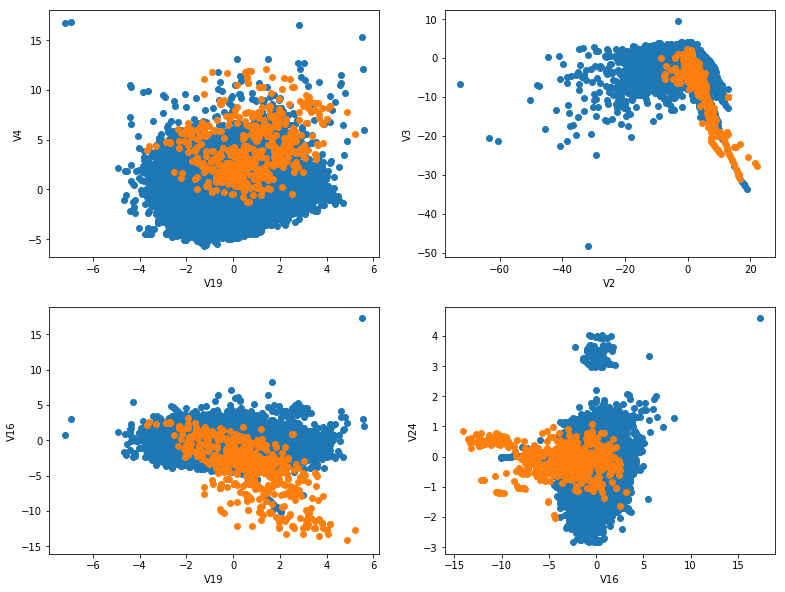

In [4]:
col_names = list(data.columns)[1:-1] ## TODO what is this?
tile_random_features(col_names, data)

### Prep data

In [5]:
train, test = train_test_split(data, test_size=0.2)

print '% of fraud cases in original, train, and test sets:'
print len(fradulent)*1.0/len(data)
print len(train[train['Class']==1])*1.0/len(train)
print len(test[test['Class']==1])*1.0/len(test)

% of fraud cases in original, train, and test sets:
0.00172748563062
0.00168974522153
0.00187844527931


In [6]:
# Split into features / class labels
train_x, train_y = [df.as_matrix() for df in split_by_class(train)]
test_x, test_y = [df.as_matrix() for df in split_by_class(test)]

## Performance Metrics

Note that a dumb majority class classifier has incredible accuracy!

In [7]:
from sklearn.metrics import accuracy_score
bs_pred = np.zeros(test_y.shape)
accuracy_score(test_y, bs_pred)

0.99812155472069097

That's hard to beat!

However what we really care about is not primarily accurancy. We want high recall so that we can find as much fraud ass possible while not creating _too_ many false positives

In [8]:
from sklearn.metrics import recall_score
print "Recall:"
recall_score(test_y, bs_pred)

Recall:


0.0

Recall is quite bad, making this a very poor classifier for finding fraud

Thus we will try to find a sampling methods that has good recall and better-than-horrible precision (or alternatively, high accurancy).

## Implement sampling methods on training data

According to we background we did to test different classifiers we are going to test our sampling methods on 3 classifiers: Logistic Regression, QDA, and Decision Trees (CART)

In [9]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [10]:
# best results from hyper parameter search
logit_params = {'penalty': 'l2', 'C': 0.01}

### Over sampling

In [11]:
from imblearn.over_sampling import RandomOverSampler
train_x_res, train_y_res = RandomOverSampler().fit_sample(train_x, train_y)
print_class_counts(train_y_res)

Class counts:
[(0, 227460), (1, 227460)]


In [12]:
run_compare_sampling(RandomOverSampler, LogisticRegression, train_x_res, train_y_res, test_x, test_y, **logit_params)
run_compare_sampling(RandomOverSampler, QuadraticDiscriminantAnalysis, train_x, train_y, test_x, test_y)
run_compare_sampling(RandomOverSampler, DecisionTreeClassifier, train_x, train_y, test_x, test_y)

Sampler: RandomOverSampler
Class counts:
[(0, 227460), (1, 227460)]

LogisticRegression
Recall: 	0.906542056075
Precision:	0.0654520917679
F1 Score:	0.12208936438
Accuracy:	0.975509989116
Confusion mat: 
[[55470  1385]
 [   10    97]]

LogisticRegression
Recall: 	0.906542056075
Precision:	0.0654520917679
F1 Score:	0.12208936438
Accuracy:	0.975509989116
Confusion mat: 
[[55470  1385]
 [   10    97]]

Sampler: RandomOverSampler
Class counts:
[(0, 227460), (1, 227460)]

QuadraticDiscriminantAnalysis
Recall: 	0.88785046729
Precision:	0.0620509470934
F1 Score:	0.115995115995
Accuracy:	0.974579544258
Confusion mat: 
[[55419  1436]
 [   12    95]]

QuadraticDiscriminantAnalysis
Recall: 	0.88785046729
Precision:	0.0458052073288
F1 Score:	0.087116001834
Accuracy:	0.965046873354
Confusion mat: 
[[54876  1979]
 [   12    95]]

Sampler: RandomOverSampler
Class counts:
[(0, 227460), (1, 227460)]

DecisionTreeClassifier
Recall: 	0.728971962617
Precision:	0.735849056604
F1 Score:	0.732394366197
Accur

### Under sampling

In [13]:
from imblearn.under_sampling import RandomUnderSampler
train_x_res, train_y_res = RandomUnderSampler().fit_sample(train_x, train_y)
print_class_counts(train_y_res)

Class counts:
[(0, 385), (1, 385)]


In [14]:
run_compare_sampling(RandomUnderSampler, LogisticRegression, train_x_res, train_y_res, test_x, test_y,**logit_params)
run_compare_sampling(RandomUnderSampler, QuadraticDiscriminantAnalysis, train_x, train_y, test_x, test_y)
run_compare_sampling(RandomUnderSampler, DecisionTreeClassifier, train_x, train_y, test_x, test_y)

Sampler: RandomUnderSampler
Class counts:
[(0, 385), (1, 385)]

LogisticRegression
Recall: 	0.897196261682
Precision:	0.0723436322532
F1 Score:	0.133891213389
Accuracy:	0.978195990309
Confusion mat: 
[[55624  1231]
 [   11    96]]

LogisticRegression
Recall: 	0.897196261682
Precision:	0.0726172465961
F1 Score:	0.134359692092
Accuracy:	0.978283768126
Confusion mat: 
[[55629  1226]
 [   11    96]]

Sampler: RandomUnderSampler
Class counts:
[(0, 385), (1, 385)]

QuadraticDiscriminantAnalysis
Recall: 	0.88785046729
Precision:	0.0620509470934
F1 Score:	0.115995115995
Accuracy:	0.974579544258
Confusion mat: 
[[55419  1436]
 [   12    95]]

QuadraticDiscriminantAnalysis
Recall: 	0.915887850467
Precision:	0.0252577319588
F1 Score:	0.0491597692501
Accuracy:	0.93344685931
Confusion mat: 
[[53073  3782]
 [    9    98]]

Sampler: RandomUnderSampler
Class counts:
[(0, 385), (1, 385)]

DecisionTreeClassifier
Recall: 	0.728971962617
Precision:	0.75
F1 Score:	0.739336492891
Accuracy:	0.999034444015
Co

### SMOTE/ADASYN oversampling

In [15]:
from imblearn.over_sampling import SMOTE, ADASYN
train_x_res, train_y_res = SMOTE(kind='regular').fit_sample(train_x, train_y)
print_class_counts(train_y_res)

Class counts:
[(0, 227460), (1, 227460)]


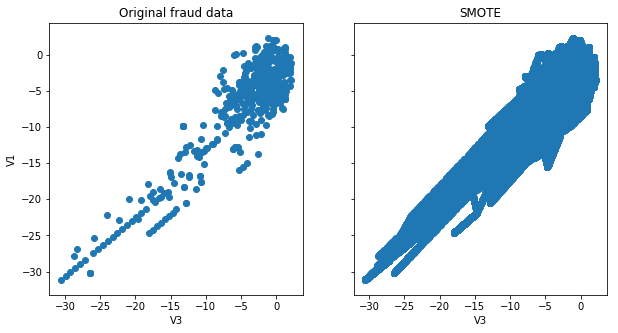

In [16]:
minorty = train_x_res[train_y_res == 1]
col_names = fradulent.columns
cols = (1,3)

fig, axarr = plt.subplots(1,2,sharey=True,figsize=(10,5))
ax_orig = axarr[0]
ax_smote = axarr[1]

ax_orig.scatter(fradulent[col_names[cols[0]]],fradulent[col_names[cols[1]]])
ax_orig.set_title('Original fraud data')
ax_orig.set_ylabel(col_names[cols[0]])
ax_orig.set_xlabel(col_names[cols[1]])

ax_smote.scatter(minorty[:,cols[0]], minorty[:,cols[1]])
ax_smote.set_title('SMOTE')
ax_smote.set_xlabel(col_names[cols[1]])

plt.show()

In [17]:
run_compare_sampling(SMOTE, LogisticRegression, train_x_res, train_y_res, test_x, test_y,**logit_params)
run_compare_sampling(SMOTE, QuadraticDiscriminantAnalysis, train_x, train_y, test_x, test_y)
run_compare_sampling(SMOTE, DecisionTreeClassifier, train_x, train_y, test_x, test_y)

Sampler: SMOTE
Class counts:
[(0, 227460), (1, 227460)]

LogisticRegression
Recall: 	0.869158878505
Precision:	0.104494382022
F1 Score:	0.186559679037
Accuracy:	0.985762438117
Confusion mat: 
[[56058   797]
 [   14    93]]

LogisticRegression
Recall: 	0.869158878505
Precision:	0.104494382022
F1 Score:	0.186559679037
Accuracy:	0.985762438117
Confusion mat: 
[[56058   797]
 [   14    93]]

Sampler: SMOTE
Class counts:
[(0, 227460), (1, 227460)]

QuadraticDiscriminantAnalysis
Recall: 	0.88785046729
Precision:	0.0620509470934
F1 Score:	0.115995115995
Accuracy:	0.974579544258
Confusion mat: 
[[55419  1436]
 [   12    95]]

QuadraticDiscriminantAnalysis
Recall: 	0.88785046729
Precision:	0.0600126342388
F1 Score:	0.112426035503
Accuracy:	0.973666654963
Confusion mat: 
[[55367  1488]
 [   12    95]]

Sampler: SMOTE
Class counts:
[(0, 227460), (1, 227460)]

DecisionTreeClassifier
Recall: 	0.775700934579
Precision:	0.741071428571
F1 Score:	0.75799086758
Accuracy:	0.999069555142
Confusion mat: 
[

In [18]:
run_compare_sampling(ADASYN, LogisticRegression, train_x_res, train_y_res, test_x, test_y, **logit_params)
run_compare_sampling(ADASYN, QuadraticDiscriminantAnalysis, train_x, train_y, test_x, test_y)
run_compare_sampling(ADASYN, DecisionTreeClassifier, train_x, train_y, test_x, test_y)

Sampler: ADASYN
Class counts:
[(0, 227460), (1, 227460)]

LogisticRegression
Recall: 	0.869158878505
Precision:	0.104494382022
F1 Score:	0.186559679037
Accuracy:	0.985762438117
Confusion mat: 
[[56058   797]
 [   14    93]]

LogisticRegression
Recall: 	0.869158878505
Precision:	0.104494382022
F1 Score:	0.186559679037
Accuracy:	0.985762438117
Confusion mat: 
[[56058   797]
 [   14    93]]

Sampler: ADASYN
Class counts:
[(0, 227460), (1, 227495)]

QuadraticDiscriminantAnalysis
Recall: 	0.88785046729
Precision:	0.0620509470934
F1 Score:	0.115995115995
Accuracy:	0.974579544258
Confusion mat: 
[[55419  1436]
 [   12    95]]

QuadraticDiscriminantAnalysis
Recall: 	0.88785046729
Precision:	0.0438394093216
F1 Score:	0.0835532102023
Accuracy:	0.963414205962
Confusion mat: 
[[54783  2072]
 [   12    95]]

Sampler: ADASYN
Class counts:
[(0, 227460), (1, 227495)]

DecisionTreeClassifier
Recall: 	0.747663551402
Precision:	0.78431372549
F1 Score:	0.765550239234
Accuracy:	0.999139777395
Confusion mat

In [25]:
len(data), len(fradulent)

(284807, 492)